In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# replace "True" and "False" with 1/0
all_data_gdf.replace({"False": 0, "True": 1}, inplace=True)

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# add column for accumulation area of each glacier
all_data_gdf['aa_avg_product'] = all_data_gdf['aar_infill_avg_product']*all_data_gdf['Area']

for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"aa_{y}"] = all_data_gdf[f"aar_{y}"]*all_data_gdf['Area']

In [5]:
### calculate each glacier's ELA, AAR variation from ela_avg_product in each year
# note that AAR can be calculated as magnitude or percent
for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"ela_anom_{y}"] = all_data_gdf[f"ela_{y}"]-all_data_gdf["ela_avg_product"]
    all_data_gdf[f"aar_anom_{y}_mag"] = all_data_gdf[f"aar_{y}"]-all_data_gdf["aar_avg_product"]
    all_data_gdf[f"aar_anom_{y}_per"] = all_data_gdf[f"aar_anom_{y}_mag"]/all_data_gdf["aar_avg_product"]

# calculate the range in ela, aar that each glacier exhibits
all_data_gdf[f"ela_range"] = all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_mag"] = all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_per"] = all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].min(axis=1)

In [6]:
# add column for the total glacier area in each O2Region
temp = all_data_gdf.groupby('O2Region')['Area'].sum().rename('O2Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O2Region"))

# add column for the total glacier area in each O3Region
temp = all_data_gdf.groupby('O3Region')['Area'].sum().rename('O3Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O3Region"))

### calculate the region-average ela, aar variation each year

In [7]:
# start by getting the full geometry for each subregion. keep this stored in a separate gdf for later
O3_geom = all_data_gdf[['geometry', 'O3Region']].dissolve(by='O3Region').reset_index()

In [8]:
# calculating total glacier number, glacier area, mean and median size, aa, and aar for each region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].count().rename('number'))
o3_df['area'] = all_data_gdf.groupby('O3Region')['Area'].sum()
o3_df['aa'] = all_data_gdf.groupby('O3Region')['aa_avg_product'].sum()
o3_df['aar'] = o3_df['aa']/o3_df['area']

# calculate dhdt for each region
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1520']
o3_df['dhdt_1520'] = all_data_gdf.groupby('O3Region')['temporary'].sum()
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1020']
o3_df['dhdt_1020'] = all_data_gdf.groupby('O3Region')['temporary'].sum()

# calculate aar each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'aa_{y}'] = all_data_gdf.groupby('O3Region')[f'aa_{y}'].sum()
    o3_df[f'aar_{y}'] = o3_df[f'aa_{y}']/o3_df['area']
    
### calculate average elas each year, for glaciers where ela was observed
for y in [2018,2019,2020,2021,2022]:
    # for this year, subset to valid ela obs
    temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
    o3_df[f'ela_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
    # do the same, but only for larger glaciers (5km2 or bigger)
    temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
    o3_df[f'ela_5km_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_5km_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()

In [9]:
### also calculate the average ela using the average product
temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
o3_df[f'ela_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
o3_df[f'ela_5km_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_5km_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

# get ela, aar anomaly each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'ela_anom_{y}'] = o3_df[f'ela_median_{y}'] - o3_df[f'ela_median']
    o3_df[f'ela_5km_anom_{y}'] = o3_df[f'ela_5km_median_{y}'] - o3_df[f'ela_5km_median']
    o3_df[f'aar_anom_{y}'] = o3_df[f'aar_{y}'] - o3_df['aar']
    
# add geometry in at the end
o3_df = gpd.GeoDataFrame(pd.merge(o3_df, O3_geom, on="O3Region"))

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0)
o3_df.columns

Index(['O3Region', 'number', 'area', 'aa', 'aar', 'dhdt_1520', 'dhdt_1020',
       'aa_2018', 'aar_2018', 'aa_2019', 'aar_2019', 'aa_2020', 'aar_2020',
       'aa_2021', 'aar_2021', 'aa_2022', 'aar_2022', 'ela_mean_2018',
       'ela_median_2018', 'ela_5km_mean_2018', 'ela_5km_median_2018',
       'ela_mean_2019', 'ela_median_2019', 'ela_5km_mean_2019',
       'ela_5km_median_2019', 'ela_mean_2020', 'ela_median_2020',
       'ela_5km_mean_2020', 'ela_5km_median_2020', 'ela_mean_2021',
       'ela_median_2021', 'ela_5km_mean_2021', 'ela_5km_median_2021',
       'ela_mean_2022', 'ela_median_2022', 'ela_5km_mean_2022',
       'ela_5km_median_2022', 'ela_mean', 'ela_median', 'ela_5km_mean',
       'ela_5km_median', 'ela_anom_2018', 'ela_5km_anom_2018', 'aar_anom_2018',
       'ela_anom_2019', 'ela_5km_anom_2019', 'aar_anom_2019', 'ela_anom_2020',
       'ela_5km_anom_2020', 'aar_anom_2020', 'ela_anom_2021',
       'ela_5km_anom_2021', 'aar_anom_2021', 'ela_anom_2022',
       'ela_5km_anom_

In [10]:
# define a 16-color categorical color palette
# http://vrl.cs.brown.edu/color
from matplotlib.colors import ListedColormap
# hex_codes = ["#a0e3b7", "#b33c85", "#37b51f", "#b32df9", "#7e9b3d", "#333dcd", "#c0e15c", "#fe7dda", "#235e31", "#be0332", "#20d8fd", "#6c3640", "#21f0b6", "#ec7f6a", "#0362a0", "#f79302"]
# hex_codes = ["#3c2d80", "#609111", "#e30293", "#20502e", "#ec102f", "#219571", "#ce5d8e", "#3d8bb7", "#b94403", "#a143f9", "#604020", "#577cf5", "#ae783e", "#4b03a9", "#9679a6", "#154975"]
hex_codes = ["#097969","#FF3131","#CC5500","#D2042D","#880808","#EC5800","#1434A4","#3d8bb7","#0000FF","#577cf5","#FFD700","#C4B454","#DA70D6","#702963","#9679a6","#9F2B68"]
cmap_16 = ListedColormap(hex_codes)

# create list of o3region numbers, names, hex codes
numbers = np.arange(1,17)
names = [ all_data_gdf[all_data_gdf['O3Region']==n]['O3_name'].values[0] for n in numbers]
colors = [ hex_codes[n-1] for n in numbers ]
names[11] = 'St Elias Mountains'

o3_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
o3_info_df

,Number,Name,Color
0,1,Aleutian Range,#097969
1,2,Northern Aleutian Range,#FF3131
2,3,Western Alaska Range,#CC5500
3,4,Central Alaska Range,#D2042D
4,5,Eastern Alaska Range,#880808
5,6,Wrangell Mountains,#EC5800
6,7,Talkeetna Mountains,#1434A4
7,8,Southern Kenai Mountains,#3d8bb7
8,9,Northern Kenai Mountains,#0000FF
9,10,Western Chugach Mountains,#577cf5


In [11]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

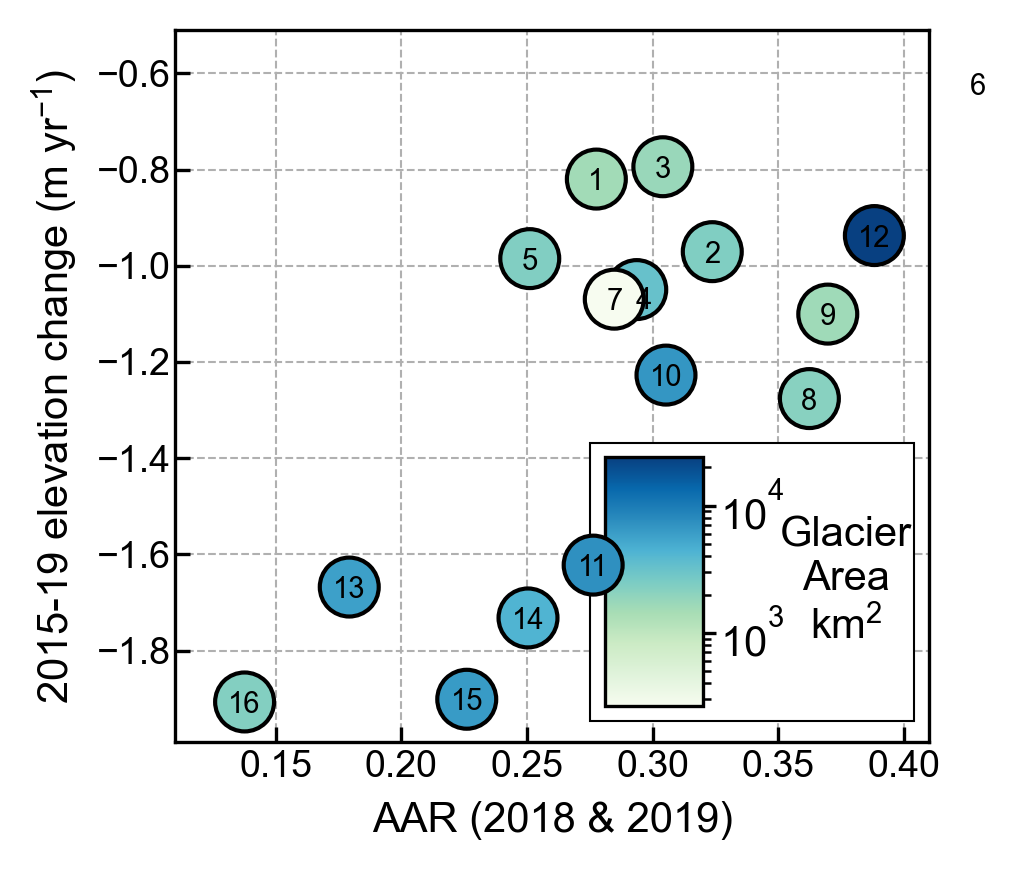

In [12]:
# plot o3region AAR vs dhdt
fig,axs = plt.subplots(figsize=(3.5,3), dpi=300)

# add data
sc = axs.scatter((o3_df['aar_2018']+o3_df['aar_2019'])/2, o3_df['dhdt_1520'], zorder=10,
                    s=200,
                    c=o3_df['area'],
                    edgecolor='black',
                    cmap="GnBu",
                    norm=LogNorm())

# add numbers to data
for i in range(len(o3_df['dhdt_1520'])):
    x = ((o3_df['aar_2018']+o3_df['aar_2019'])/2).values[i]
    y = o3_df['dhdt_1520'].values[i]
    t = o3_df['O3Region'].values[i]
    if t!=4:
        axs.text(x,y,t, size=7, zorder=11,
                horizontalalignment='center',
                verticalalignment='center_baseline',)
    else:
        axs.text(x-0.0005,y+0.005,t, size=7, zorder=11,
                horizontalalignment='left',
                verticalalignment='top',)

# create inset axis for colorbar
cb_ax = axs.inset_axes( (0.57,0.05,0.13,0.35), transform=axs.transAxes)

# add colorbar
plt.colorbar(sc, cax=cb_ax)

# edit cbar axis
cb_ax.tick_params(labelsize=10, length=3, pad=1)
cb_ax.set_ylabel('Glacier\nArea\nkm$^2$', size=10, labelpad=15, rotation=0, va="center")
# cb_ax.yaxis.set_label_position('left') 

# add background to cbar axix
rect = Rectangle((0.55,0.03), 0.43, 0.39, transform=axs.transAxes,
                 fc='white', ec='black', fill=True, lw=0.5, zorder=2)
axs.add_patch(rect)

# set tick and label stuff
axs.set_xlabel("AAR (2018 & 2019)", fontsize = 10)
axs.set_ylabel("2015-19 elevation change (m yr$^{-1}$)", fontsize = 10)
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
axs.set_xlim(0.11,0.41)
axs.set_ylim(-1.99, -0.51)

# add grid
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'hugonnet.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

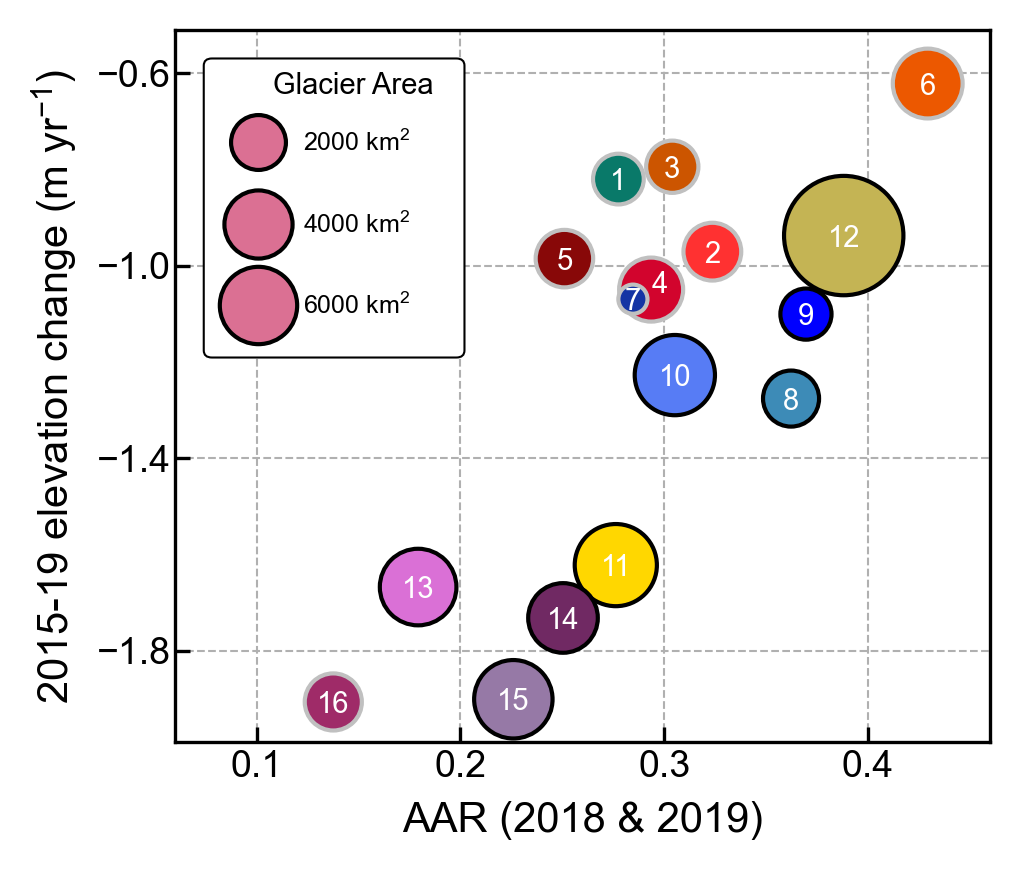

In [23]:
# plot o3region AAR vs dhdt
fig,axs = plt.subplots(figsize=(3.5,3), dpi=300)

# define edge colors
c_land = 'silver'
c_marine = 'black'
edgecolors = [ c_land,c_land,c_land,c_land,c_land,c_land,c_land, #1-7
               c_marine,c_marine,c_marine,c_marine,c_marine,c_marine,c_marine,c_marine, #8-15
               c_land,] #16

# add data
sc = axs.scatter((o3_df['aar_2018']+o3_df['aar_2019'])/2, o3_df['dhdt_1520'], zorder=10,
                    marker='o',
                    s=(o3_df["area"]**(1/1.6))*1.5,
                    c=colors,
                    edgecolor=edgecolors)
#                     edgecolor='black',)

# add numbers to data
all_x = []
all_y = []
for i in range(len(o3_df['dhdt_1520'])):
    x = ((o3_df['aar_2018']+o3_df['aar_2019'])/2).values[i]
    y = o3_df['dhdt_1520'].values[i]
    t = o3_df['O3Region'].values[i]
    if t!=4:
        axs.text(x,y,t, size=7, zorder=11,
                horizontalalignment='center',
                verticalalignment='center_baseline',color='white')
    else:
        axs.text(x,y-0.02,t, size=7, zorder=11,
                horizontalalignment='left',
                verticalalignment='bottom',color='white')
    
    all_x.append(x)
    all_y.append(y)


# add background for legend first axix
rect = FancyBboxPatch((0.045,0.55), 0.3, 0.4, boxstyle="Round, pad=0.01", transform=axs.transAxes,
                 fc='white', ec='black', fill=True, lw=0.5, zorder=2)
axs.add_patch(rect)

# add legend title
axs.text(0.12,0.91,'Glacier Area',
         transform=axs.transAxes, fontsize=7)

# create legend
handles, labels = sc.legend_elements(prop="sizes", markeredgecolor='black',
                                     alpha=1, num=12, markerfacecolor="palevioletred",
                                     fmt="{x:.0f} km$^2$",
                                     func = lambda s: (s/1.5)**1.6 )

axs.legend(handles=[handles[0],handles[1],handles[2]], labels=[labels[0],labels[1],labels[2]],
           loc='upper left', bbox_to_anchor=(0.01,0.93), ncols=1,
           title='', title_fontsize=6,
           fontsize=6, labelspacing=2.2, borderpad=1.5, 
           framealpha=0, edgecolor=None, shadow=False, fancybox=True)

# set tick and label stuff
axs.set_xlabel("AAR (2018 & 2019)", fontsize = 10)
axs.set_ylabel("2015-19 elevation change (m yr$^{-1}$)", fontsize = 10)
axs.set_yticks([-0.6, -1.0, -1.4, -1.8])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
axs.set_xlim(0.06,0.46)
axs.set_ylim(-1.99, -0.51)

# add grid
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'hugonnet_final.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [14]:
# find r2
lr = LinearRegression().fit(np.array(all_x).reshape(-1, 1), all_y)#, sample_weight=o3_df["area"])
lr.score(np.array(all_x).reshape(-1, 1), all_y)#, sample_weight=o3_df["area"])
# lr.get_params()

0.538647341849886